### Introduction

An example of implementing the Metapath2Vec representation learning algorithm using components from the `stellargraph` and `gensim` libraries.

**References**

**1.**  Metapath2Vec: Scalable Representation Learning for Heterogeneous Networks. Yuxiao Dong, Nitesh V. Chawla, and Ananthram Swami. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 135–144, 2017. ([link](https://ericdongyx.github.io/papers/KDD17-dong-chawla-swami-metapath2vec.pdf))

**2.** Distributed representations of words and phrases and their compositionality. T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado, and J. Dean.  In Advances in Neural Information Processing Systems (NIPS), pp. 3111-3119, 2013. ([link](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf))

**3.** Gensim: Topic modelling for humans. ([link](https://radimrehurek.com/gensim/))

**4.** Social Computing Data Repository at ASU [http://socialcomputing.asu.edu]. R. Zafarani and H. Liu. Tempe, AZ: Arizona State University, School of Computing, Informatics and Decision Systems Engineering. 2009.

In [1]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph.data.loader import load_dataset_BlogCatalog3

%matplotlib inline

### Load the dataset

The dataset is the BlogCatalog3 network.

It can be downloaded from [here.](http://socialcomputing.asu.edu/datasets/BlogCatalog3)

The following is the description of the dataset from the publisher [4]:

> This is the data set crawled from BlogCatalog ( http://www.blogcatalog.com ). BlogCatalog is a social blog directory website. This contains the friendship network crawled and group memberships. For easier understanding, all the contents are organized in CSV file format.

The statistics of this network are,

- Number of bloggers : 10,312
- Number of friendship pairs: 333,983
- Number of groups: 39

We assume that the dataset file `BlogCatalog-dataset.zip` has been downloaded and unzipped in the directory,

`~/data`

and the data in `csv` format (the files `edges.csv`, `nodes.csv`, `groups.csv`, and `group-edges.csv` can be found in directory,

`~/data/BlogCatalog-dataset/data/`

In [2]:
dataset_location = os.path.expanduser("~/data/BlogCatalog-dataset/data")
g_nx = load_dataset_BlogCatalog3(location=dataset_location)
print("Number of nodes {} and number of edges {} in graph.".format(g_nx.number_of_nodes(), g_nx.number_of_edges()))

Number of nodes 10351 and number of edges 348459 in graph.


### The Metapath2Vec algorithm

The Metapath2Vec algorithm introduced in [1] is a 2-step representation learning algorithm. The two steps are:

1. Use uniform random walks to generate sentences from a graph. A sentence is a list of node IDs. The set of all sentences makes a corpus. The random walk is driven by a metapath that defines the node type order by which the random walker explores the graph.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node ID is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The Word2Vec algorithm [2] is used for calculating the embedding vectors.

## Corpus generation using random walks

The `stellargraph` library provides an implementation for uniform, first order, random walks as required by Metapath2Vec. The random walks have fixed maximum length and are controlled by the list of metapath schemas specified in parameter `metapaths`. 

A metapath schema defines the type of node that the random walker is allowed to transition to from its current location. In the `stellargraph` implementation of metapath-driven random walks, the metapath schemas are given as a list of node types under the assumption that the input graph is not a multi-graph, i.e., two nodes are only connected by one edge type.

See [1] for a detailed description of metapath schemas and metapth-driven random walks.

For the **BlogCatalog3** dataset we use the following 3 metapaths.

- "user", "group", "user"
- "user", "group", "user", "user"
- "user", "user"



In [4]:
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(g_nx))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["user", "group", "user"],
    ["user", "group", "user", "user"],
    ["user", "user"],
]

walks = rw.run(nodes=list(g_nx.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths  # the metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 30936


### Representation Learning using Word2Vec

We use the Word2Vec [2] implementation in the free Python library gensim [3] to learn representations for each node in the graph.

We set the dimensionality of the learned embedding vectors to 128 as in [1].

In [5]:
from gensim.models import Word2Vec

model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [6]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(10351, 128)

### Visualise Node Embeddings

We retrieve the Word2Vec node embeddings that are 128-dimensional vectors and then we project them down to 2 dimensions using the [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm.

In [7]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ g_nx.node[node_id]['label'] for node_id in node_ids]

In [8]:
# Apply t-SNE transform to node embeddings, for visualisation
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

Text(0.5,1,'t-SNE visualization of node embeddings')

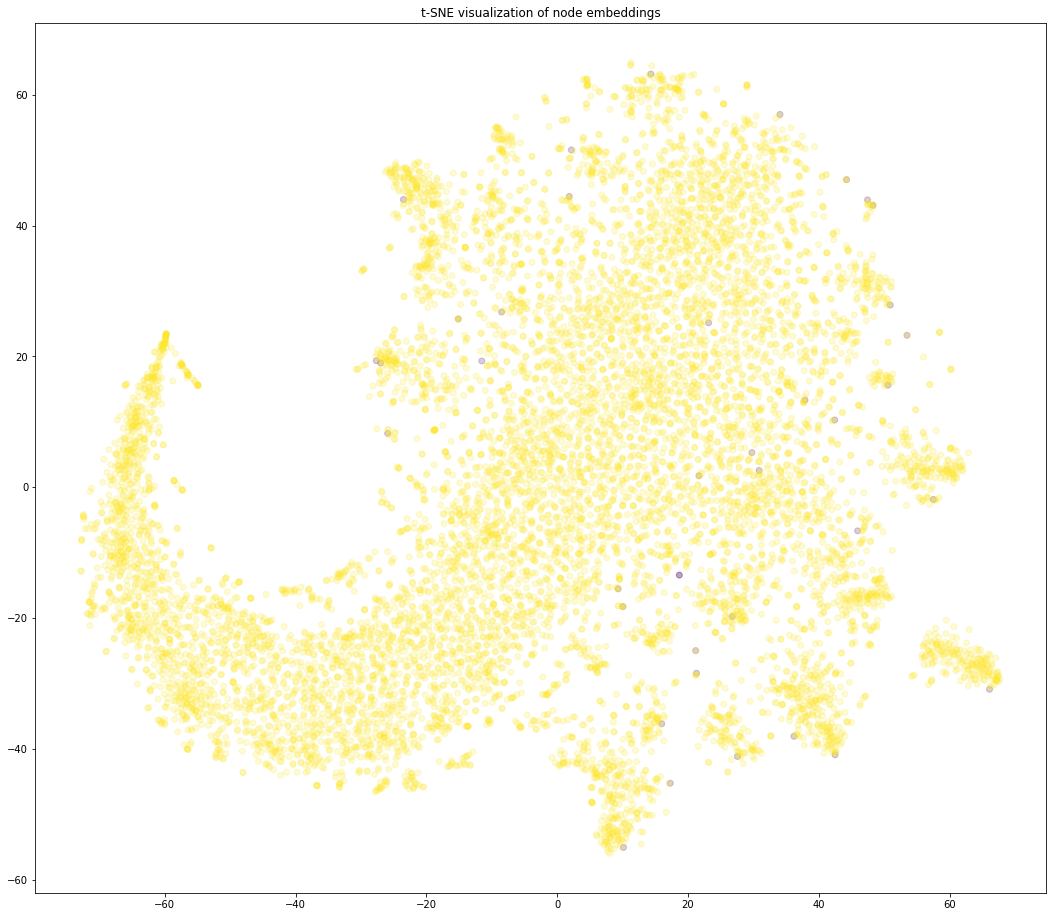

In [9]:
# draw the points
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.2)
plt.title('t-SNE visualization of node embeddings')

### Downstream task

The node embeddings calculated using Metapath2Vec can be used as feature vectors in a downstream task such as node attribute inference (e.g., inferring the gender or age attribute of 'user' nodes), community detection (e.g., clustering of 'user' nodes based on the similarity of their embedding vectors), and link prediction (e.g., prediction of friendship relation between 'user' nodes).